# Análise de Sentimentos usando Machine Learning

Vamos criar modelos para análise de sentimentos de tweets. Para isso, vamos testar:

* modelos usando tag de negações
* modelos usando Bigrams

In [1]:
from nltk import word_tokenize
import nltk
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

In [26]:
dataset = pd.read_csv('Tweets_Mg.csv', encoding='utf-8')

In [3]:
dataset.Text.head(50)

0     ���⛪ @ Catedral de Santo Antônio - Governador ...
1     � @ Governador Valadares, Minas Gerais https:/...
2     �� @ Governador Valadares, Minas Gerais https:...
3                           ��� https://t.co/BnDsO34qK0
4     ��� PSOL vai questionar aumento de vereadores ...
5     " bom é bandido morto"\nDeputado Cabo Júlio é ...
6     "..E 25% dos mineiros dizem não torcer para ti...
7     "A gigantesca barba do mal" em destaque no cad...
8     "BB e governo de Minas travam disputa sobre de...
9     "com vcs bh fica pequena!" Belo Horizonte (pro...
10    "Daí a gente visita governador valadares"\n"Qu...
11    "É bonita e é bonita..." \n#latergram #ibituru...
12    "erro desconhecido" é mato! Aliás, é da secret...
13    "La La Land: Cantando Estações" arrasa no Glob...
14    "La La Land: Cantando Estações" arrasa no Glob...
15    "Los abusos, aun en el estado más sólido, son ...
16    "Mesmo sem muito dinheiro no caixa o governo d...
17    "Modelo de segurança será o nosso legado",

In [4]:
# Conta a quantidade de linhas de tweets neutros, positivos e negativos
dataset[dataset.Classificacao=='Neutro'].count()

Unnamed: 0                   2453
Created At                   2453
Text                         2453
Geo Coordinates.latitude      102
Geo Coordinates.longitude     102
User Location                1712
Username                     2453
User Screen Name             2453
Retweet Count                2453
Classificacao                2453
Observação                      0
Unnamed: 10                     0
Unnamed: 11                     0
Unnamed: 12                     0
Unnamed: 13                     0
Unnamed: 14                     0
Unnamed: 15                     0
Unnamed: 16                     0
Unnamed: 17                     0
Unnamed: 18                     0
Unnamed: 19                     0
Unnamed: 20                     0
Unnamed: 21                     0
Unnamed: 22                     0
Unnamed: 23                     0
Unnamed: 24                     0
dtype: int64

In [5]:
dataset[dataset.Classificacao=='Positivo'].count()

Unnamed: 0                   3300
Created At                   3300
Text                         3300
Geo Coordinates.latitude        1
Geo Coordinates.longitude       1
User Location                2118
Username                     3300
User Screen Name             3300
Retweet Count                3300
Classificacao                3300
Observação                      1
Unnamed: 10                     0
Unnamed: 11                     0
Unnamed: 12                     0
Unnamed: 13                     0
Unnamed: 14                     0
Unnamed: 15                     0
Unnamed: 16                     0
Unnamed: 17                     0
Unnamed: 18                     0
Unnamed: 19                     0
Unnamed: 20                     0
Unnamed: 21                     0
Unnamed: 22                     0
Unnamed: 23                     0
Unnamed: 24                     0
dtype: int64

In [6]:
dataset[dataset.Classificacao=='Negativo'].count()

Unnamed: 0                   2446
Created At                   2446
Text                         2446
Geo Coordinates.latitude        1
Geo Coordinates.longitude       1
User Location                1659
Username                     2446
User Screen Name             2446
Retweet Count                2446
Classificacao                2446
Observação                      0
Unnamed: 10                     0
Unnamed: 11                     0
Unnamed: 12                     0
Unnamed: 13                     0
Unnamed: 14                     0
Unnamed: 15                     0
Unnamed: 16                     0
Unnamed: 17                     0
Unnamed: 18                     0
Unnamed: 19                     0
Unnamed: 20                     0
Unnamed: 21                     0
Unnamed: 22                     0
Unnamed: 23                     0
Unnamed: 24                     0
dtype: int64

<AxesSubplot:>

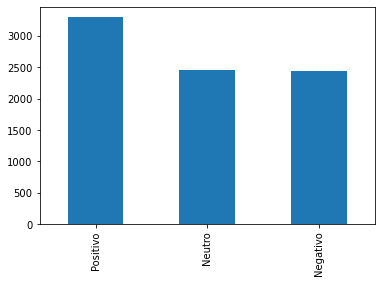

In [7]:
%matplotlib inline
dataset.Classificacao.value_counts().plot(kind='bar')

In [8]:
dataset.count()

Unnamed: 0                   8199
Created At                   8199
Text                         8199
Geo Coordinates.latitude      104
Geo Coordinates.longitude     104
User Location                5489
Username                     8199
User Screen Name             8199
Retweet Count                8199
Classificacao                8199
Observação                      1
Unnamed: 10                     0
Unnamed: 11                     0
Unnamed: 12                     0
Unnamed: 13                     0
Unnamed: 14                     0
Unnamed: 15                     0
Unnamed: 16                     0
Unnamed: 17                     0
Unnamed: 18                     0
Unnamed: 19                     0
Unnamed: 20                     0
Unnamed: 21                     0
Unnamed: 22                     0
Unnamed: 23                     0
Unnamed: 24                     0
dtype: int64

## Pre-Processamento dos Dados

* Remoção de linhas duplicadas na base de dados
    - Problema na coleta dos dados.
* Remoção de Stopwords
* Stemming nos dados
* Remoção de caracteres indesejados como links, pontuação etc.

In [9]:
dataset.drop_duplicates(['Text'], inplace=True)

In [10]:
dataset.Text.count()

5765

## Separando tweets e suas Classes

In [27]:
tweets = dataset['Text']
classes = dataset['Classificacao']

In [12]:
import nltk
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /home/ls/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /home/ls/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

### Funções para o pré processmento dos dados

In [13]:
def remove_stopwords(instancia):
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if i not in stopwords]
    return (" ".join(palavras))

In [14]:
def stemming(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in instancia.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

In [15]:
def data_cleaning(instancia):
    # remove links, pontos, virgulas,ponto e virgulas dos tweets
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    return instancia

**Entenda como funciona cada função**

In [16]:
remove_stopwords('Eu não gosto do partido, e também não votaria novamente nesse governante!')

'Eu gosto partido, votaria novamente nesse governante!'

In [16]:
stemming('Eu não gosto do partido, e também não votaria novamente nesse governante!')

'eu não gost do partido, e também não vot nov ness governante!'

In [17]:
data_cleaning('Assita aqui o video do Governador falando sobre a CEMIG https://www.uol.com.br :) ;)')

'assita aqui o video do governador falando sobre a cemig   '

**Aplica as 3 funções de Pre-processamento nos dados**

In [28]:
def preprocessing(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    instancia = data_cleaning(instancia)
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [stemmer.stem(i) for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

# Aplica a função em todos os dados:
tweets = [preprocessing(tweet) for tweet in tweets]

In [29]:
preprocessing('Eu não gosto do partido, e também não votaria novamente nesse governante. Assita o video aqui https:// :)')

'gost partido, vot nov ness govern assit vide aqu'

In [30]:
tweets[:10]

['���⛪ @ catedr sant antôni govern valadares/mg',
 '� @ govern valadares, min geral',
 '�� @ govern valadares, min geral',
 '���',
 '��� psol vai quest aument vere prefeit bh justiç poli est min',
 '" bom band morto" deput cab júli conden fic ineleg 10 ano poli est min',
 '"e 25% min diz torc tim nenhum,mesm dentr est atléticomg cruz pq?"',
 '"a gigantesc barb mal" destaqu cadern cult est min',
 '"bb govern min tr disput sobr depósit judiciais"',
 '"com vc bh fic pequena!" bel horizont (pron [bɛloɾiˈzõntʃi][10] capit est mg, áre aproximad 331 km²']

## Criando o modelo

In [31]:
# Instancia o objeto que faz a vetorização dos dados de texto
vectorizer = CountVectorizer(analyzer="word")

In [32]:
# Aplica o vetorizador nos dados de texto
freq_tweets = vectorizer.fit_transform(tweets)
type(freq_tweets)

scipy.sparse.csr.csr_matrix

In [33]:
modelo = MultinomialNB()
modelo.fit(freq_tweets, classes)

MultinomialNB()

In [34]:
freq_tweets.shape

(8199, 5903)

In [35]:
freq_tweets.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [36]:
# Testando o modelo com algumas instâncias simples
# defina instâncias de teste dentro de uma lista
testes = ['Esse governo está no início, vamos ver o que vai dar',
          'Estou muito feliz com o governo de Minas esse ano',
          'O estado de Minas Gerais decretou calamidade financeira!!!',
          'A segurança desse país está deixando a desejar',
          'O governador de Minas é mais uma vez do PT']

In [37]:
testes = [preprocessing(i) for i in testes]

In [38]:
# Transforma os dados de teste em vetores de palavras
freq_testes = vectorizer.transform(testes)

In [39]:
# Fazendo a classificação com o modelo treinado.
for t, c in zip (testes, modelo.predict(freq_testes)):
    print (t +", "+ c)

govern início, vam ver vai dar, Neutro
feliz govern min ano, Neutro
est min geral decret calam financeira!!!, Negativo
seguranç dess país deix desej, Neutro
govern min vez pt, Negativo


In [40]:
# Probabilidades de cada classe
print(modelo.classes_)
modelo.predict_proba(freq_testes).round(2)

['Negativo' 'Neutro' 'Positivo']


array([[0.04, 0.96, 0.  ],
       [0.01, 0.96, 0.03],
       [1.  , 0.  , 0.  ],
       [0.03, 0.94, 0.02],
       [0.72, 0.28, 0.01]])

### Função de Tags de Negações

* Acrescenta uma tag _NEG encontrada após um 'não'.
* Objetivo é dar mais peso para o modelo identificar uma inversão de sentimento da frase.
* Exemplos: 
    - Eu gosto de cachorros, positivo.
    - Eu **não** gosto de cachorros, negativo.

In [41]:
def marque_negacao(texto):
    negacoes = ['não','not']
    negacao_detectada = False
    resultado = []
    palavras = texto.split()
    for p in palavras:
        p = p.lower()
        if negacao_detectada == True:
            p = p + '_NEG'
        if p in negacoes:
            negacao_detectada = True
        resultado.append(p)
    return (" ".join(resultado))

In [42]:
marque_negacao('Eu gosto do partido, votaria novamente nesse governante!')

'eu gosto do partido, votaria novamente nesse governante!'

In [43]:
marque_negacao('Eu Não gosto do partido, e também não votaria novamente nesse governante!')

'eu não gosto_NEG do_NEG partido,_NEG e_NEG também_NEG não_NEG votaria_NEG novamente_NEG nesse_NEG governante!_NEG'

### Criando modelos com Pipelines

In [44]:
# Pipelines são interessantes para reduzir código e automatizar fluxos
from sklearn.pipeline import Pipeline

In [45]:
pipeline_simples = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', MultinomialNB())
])

In [46]:
# Pipeline que atribui tag de negacoes nas palavras
pipeline_negacoes = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: marque_negacao(text))),
  ('classifier', MultinomialNB())
])

In [47]:
pipeline_simples.fit(tweets, classes)

Pipeline(steps=[('counts', CountVectorizer()), ('classifier', MultinomialNB())])

In [48]:
pipeline_simples.steps

[('counts', CountVectorizer()), ('classifier', MultinomialNB())]

In [49]:
pipeline_negacoes.fit(tweets,classes)

Pipeline(steps=[('counts',
                 CountVectorizer(tokenizer=<function <lambda> at 0x7f8d3ce2c040>)),
                ('classifier', MultinomialNB())])

In [50]:
pipeline_negacoes.steps

[('counts', CountVectorizer(tokenizer=<function <lambda> at 0x7f8d3ce2c040>)),
 ('classifier', MultinomialNB())]

### Validando os Modelos com Validação Cruzada

In [51]:
resultados = cross_val_predict(pipeline_simples, tweets, classes, cv=10)

In [52]:
# Medindo a acurácia média do modelo
metrics.accuracy_score(classes, resultados)

0.8725454323698012

In [53]:
print(metrics.classification_report(classes, resultados))

              precision    recall  f1-score   support

    Negativo       0.89      0.90      0.90      2446
      Neutro       0.78      0.85      0.81      2453
    Positivo       0.94      0.87      0.90      3300

    accuracy                           0.87      8199
   macro avg       0.87      0.87      0.87      8199
weighted avg       0.88      0.87      0.87      8199



In [54]:
print(pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   Negativo  Neutro  Positivo   All
Real                                      
Negativo      2203     226        17  2446
Neutro         199    2089       165  2453
Positivo        61     377      2862  3300
All           2463    2692      3044  8199


### Modelo com a Tag de Negações

In [56]:
resultados = cross_val_predict(pipeline_negacoes, tweets, classes, cv=10)

In [57]:
# Medindo a acurácia média do modelo
metrics.accuracy_score(classes, resultados)

0.6855714111477009

In [58]:
print(metrics.classification_report(classes,resultados))

              precision    recall  f1-score   support

    Negativo       0.76      0.67      0.71      2446
      Neutro       0.62      0.58      0.60      2453
    Positivo       0.69      0.78      0.73      3300

    accuracy                           0.69      8199
   macro avg       0.69      0.67      0.68      8199
weighted avg       0.69      0.69      0.68      8199



In [59]:
print(pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   Negativo  Neutro  Positivo   All
Real                                      
Negativo      1628     336       482  2446
Neutro         342    1413       698  2453
Positivo       180     540      2580  3300
All           2150    2289      3760  8199


### Avaliando modelo com Bigrams

In [60]:
'eu gosto', 'gosto do' , 'do brasil'

('eu gosto', 'gosto do', 'do brasil')

In [61]:
vectorizer = CountVectorizer(ngram_range=(1,2))
freq_tweets = vectorizer.fit_transform(tweets)
modelo = MultinomialNB()
modelo.fit(freq_tweets, classes)

MultinomialNB()

In [62]:
resultados = cross_val_predict(modelo, freq_tweets, classes, cv=10)

In [63]:
metrics.accuracy_score(classes, resultados)

0.8908403463837054

In [64]:
print (metrics.classification_report(classes,resultados))

              precision    recall  f1-score   support

    Negativo       0.90      0.92      0.91      2446
      Neutro       0.81      0.87      0.84      2453
    Positivo       0.96      0.88      0.92      3300

    accuracy                           0.89      8199
   macro avg       0.89      0.89      0.89      8199
weighted avg       0.90      0.89      0.89      8199



In [65]:
print(pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   Negativo  Neutro  Positivo   All
Real                                      
Negativo      2258     181         7  2446
Neutro         191    2146       116  2453
Positivo        63     337      2900  3300
All           2512    2664      3023  8199


## Considerações Finais

* Considere aumentar a quantidade de dados de treino.

* Pela sua simplicidade o Naive Bayes pode ser usado perfeitamente como um algoritmo de Baseline.

* Considere alterar os parâmetros do algoritmo.